Öncelikle gerekli kütüphaneleri import ettik.

In [1]:
import os
import random
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
from PIL import Image

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Input, BatchNormalization
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from skimage.transform import resize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg




Kullanacağımız verisetini sisteme tanımladık. 

In [2]:
dataset_dir = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'

Verisetindeki resim dosyalarını tarayarak resimleri ve etiketleri Pandas DataFrame'ine kaydettik. 

In [3]:
label = []
path = []

for dir_name, _, filenames in os.walk(dataset_dir):
    for filename in filenames:
        if os.path.splitext(filename)[-1] == '.png':  # Eğer dosya png ise
            if dir_name.split('/')[-1] != 'GT':  # Klasör GT içermiyorsa
                label.append(os.path.split(dir_name)[-1])  # Klasör ismini etiket olarak al
                path.append(os.path.join(dir_name, filename))  # Dosya yolunu kaydet

# Pandas DataFrame oluşturma
data = pd.DataFrame(columns=['path', 'label'])
data['path'] = path
data['label'] = label

# Data'yı inceleyelim
print(data.head())

                                                path            label
0  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
1  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
2  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
3  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
4  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel


Veri setinin genel yapısını (satır ve sütun sayısını) görüntüledik.

In [4]:
print(data.shape)

(18000, 2)


Verisetinde bulunan veri tiplerini inceledik.

In [5]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    18000 non-null  object
 1   label   18000 non-null  object
dtypes: object(2)
memory usage: 281.4+ KB
None


Eksik değerleri kontrol ettik. 

In [6]:
print(data.isnull().sum())

path     0
label    0
dtype: int64


Etiketlerin benzersiz değerlerini görüntüledik.

In [7]:
print(data['label'].unique())

['Hourse Mackerel' 'Hourse Mackerel GT' 'Black Sea Sprat GT'
 'Black Sea Sprat' 'Sea Bass' 'Sea Bass GT' 'Red Mullet' 'Red Mullet GT'
 'Trout' 'Trout GT' 'Striped Red Mullet GT' 'Striped Red Mullet'
 'Shrimp GT' 'Shrimp' 'Gilt-Head Bream GT' 'Gilt-Head Bream'
 'Red Sea Bream' 'Red Sea Bream GT']


Etiket sayılarının her bir sınıf için dağılımını gösterdik.

In [8]:
print(data['label'].value_counts())

label
Hourse Mackerel          1000
Hourse Mackerel GT       1000
Black Sea Sprat GT       1000
Black Sea Sprat          1000
Sea Bass                 1000
Sea Bass GT              1000
Red Mullet               1000
Red Mullet GT            1000
Trout                    1000
Trout GT                 1000
Striped Red Mullet GT    1000
Striped Red Mullet       1000
Shrimp GT                1000
Shrimp                   1000
Gilt-Head Bream GT       1000
Gilt-Head Bream          1000
Red Sea Bream            1000
Red Sea Bream GT         1000
Name: count, dtype: int64


Bu dağılımı grafikle de görselleştirdik.

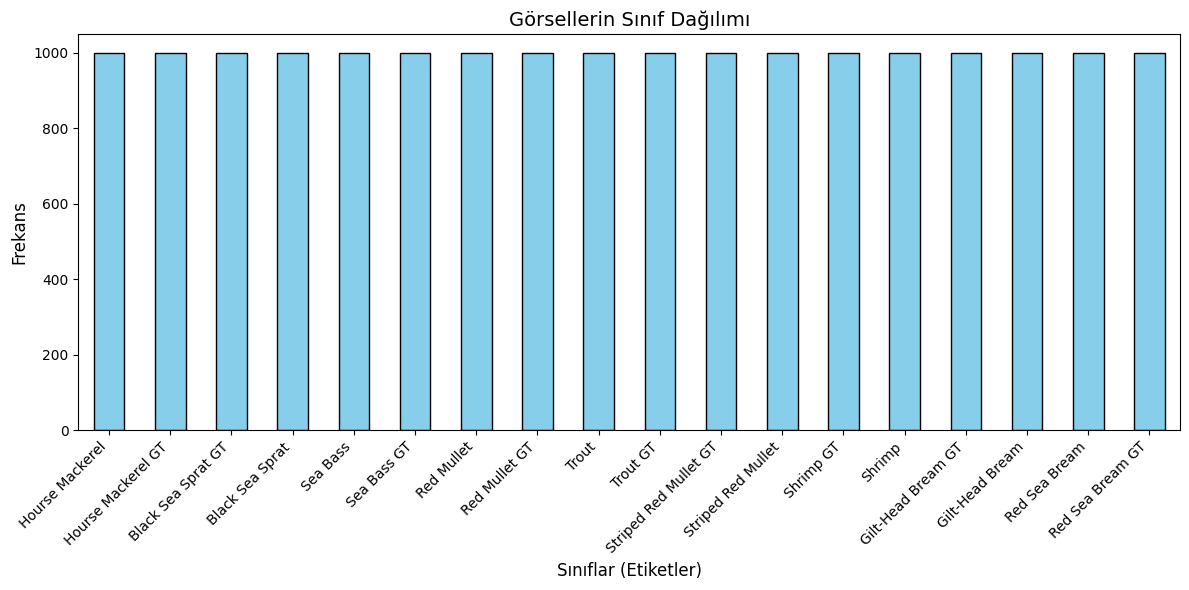

In [9]:
label_counts = data['label'].value_counts()

# Bar grafiği oluşturma
plt.figure(figsize=(12, 6))
label_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Başlık ve etiketler
plt.title('Görsellerin Sınıf Dağılımı', fontsize=14)
plt.xlabel('Sınıflar (Etiketler)', fontsize=12)
plt.ylabel('Frekans', fontsize=12)

# Görselleştirmeyi gösterme
plt.xticks(rotation=45, ha='right')  # Etiketleri döndürme
plt.tight_layout()
plt.show()


Random fonksiyonunu kullanarak verisetinde bulunan rastegele 5 görselleştirdik.

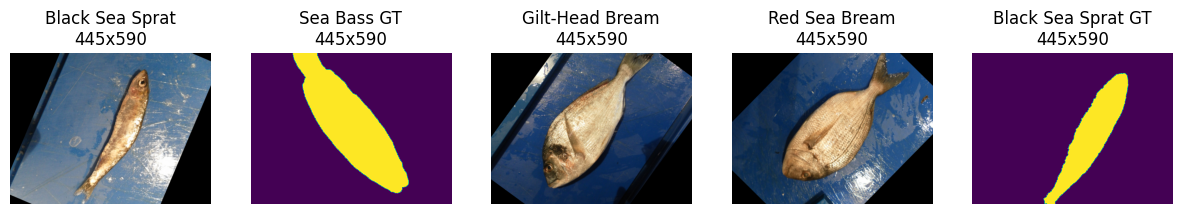

In [10]:
random_images = random.sample(list(data['path']), 5)

# 5 resim için bir grid oluşturma
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

# Resimleri görselleştirme
for i, img_path in enumerate(random_images):
    img = mpimg.imread(img_path)  # Resmi okuma
    axes[i].imshow(img)  # Resmi çizme
    axes[i].axis('off')  # Eksenleri kaldırma
    axes[i].set_title(f"{data[data['path'] == img_path]['label'].values[0]}\n{img.shape[0]}x{img.shape[1]}")  # Etiket başlığı ve boyutlar

plt.show()


Dataframe'e kaydettiğimiz görsellerin boyutlarını kontrol ettik. Modelin daha iyi eğitilmesi açısından hepsinin aynı boyutta olduğundan emin olduk.

In [11]:
# Görsellerin boyutlarını kontrol etmek için bir liste
image_sizes = []

# DataFrame'deki her görseli kontrol et
for img_path in data['path']:
    try:
        with Image.open(img_path) as img:
            image_sizes.append(img.size)  # (width, height) olarak boyutları ekle
    except Exception as e:
        print(f"Hata: {e} - Dosya: {img_path}")

# Benzersiz boyutları kontrol et
unique_sizes = set(image_sizes)

# Sonuçları yazdır
print("Benzersiz boyutlar:", unique_sizes)
print("Benzersiz boyut sayısı:", len(unique_sizes))


Benzersiz boyutlar: {(590, 445)}
Benzersiz boyut sayısı: 1


Memory hatasından dolayı sadece 5 görselin piksel dağılımını grafikle gösterdik.

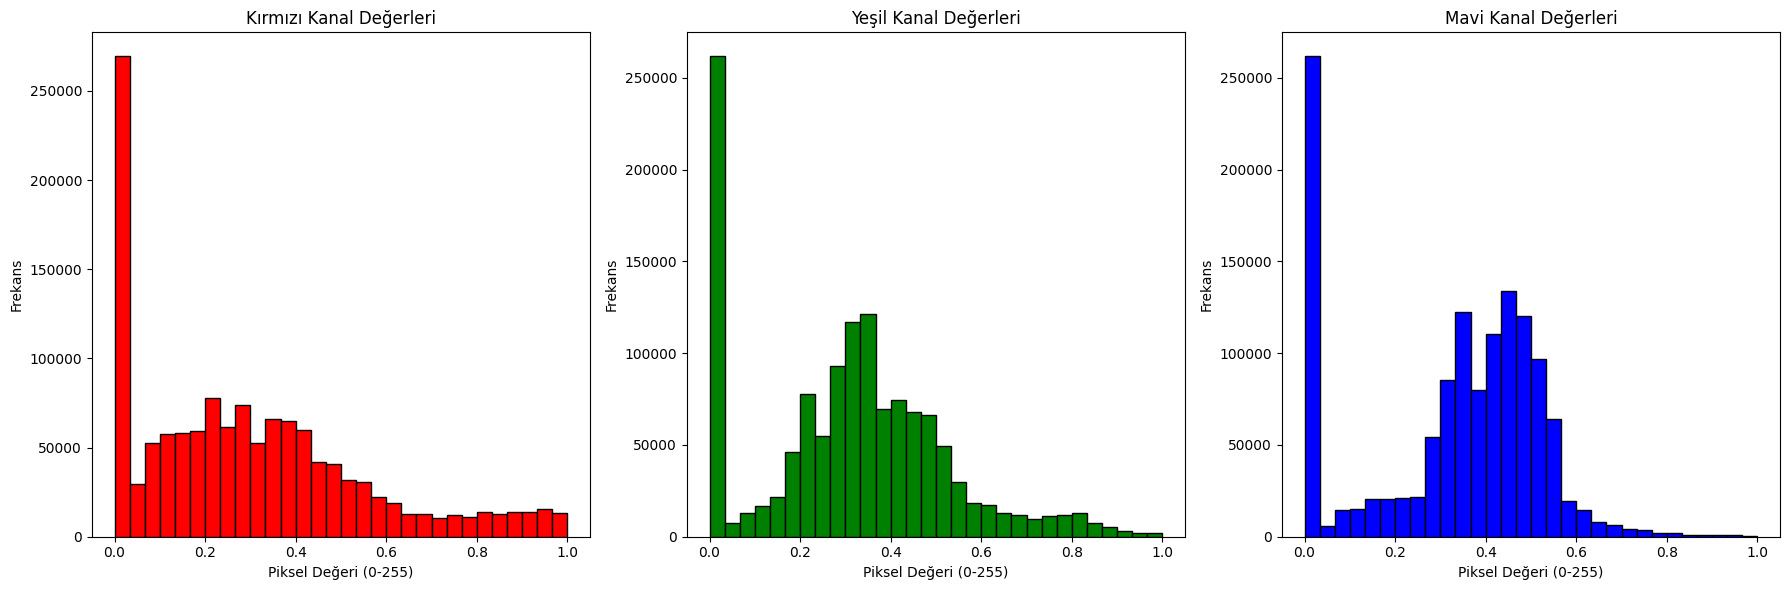

In [12]:
subset_data = data['path'][:5]

# RGB kanallarının değerlerini toplamak için listeler
red_values = []
green_values = []
blue_values = []

for img_path in subset_data:
    img = mpimg.imread(img_path)  # Görseli oku
    red_values.extend(img[:,:,0].flatten())  # Kırmızı kanal
    green_values.extend(img[:,:,1].flatten())  # Yeşil kanal
    blue_values.extend(img[:,:,2].flatten())  # Mavi kanal

# Histogramları oluşturma
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Kırmızı kanal histogramı
axes[0].hist(red_values, bins=30, color='red', edgecolor='black')
axes[0].set_title('Kırmızı Kanal Değerleri')
axes[0].set_xlabel('Piksel Değeri (0-255)')
axes[0].set_ylabel('Frekans')

# Yeşil kanal histogramı
axes[1].hist(green_values, bins=30, color='green', edgecolor='black')
axes[1].set_title('Yeşil Kanal Değerleri')
axes[1].set_xlabel('Piksel Değeri (0-255)')
axes[1].set_ylabel('Frekans')

# Mavi kanal histogramı
axes[2].hist(blue_values, bins=30, color='blue', edgecolor='black')
axes[2].set_title('Mavi Kanal Değerleri')
axes[2].set_xlabel('Piksel Değeri (0-255)')
axes[2].set_ylabel('Frekans')

plt.tight_layout()
plt.show()


Verilerin %75'ini train set, %15'ini test set ve %10'unu da validation set olarak ayırdık.

In [13]:
# Veri karıştırma ve bölme
train_data, temp_data, train_labels, temp_labels = train_test_split(
    data['path'], data['label'], test_size=0.25, stratify=data['label'], random_state=42
)

# Test ve validation setlerini ayırma (%15 test, %10 validation)
test_data, val_data, test_labels, val_labels = train_test_split(
    temp_data, temp_labels, test_size=0.4, stratify=temp_labels, random_state=42
)

# DataFrame'lere dönüştürme
train_df = pd.DataFrame({'path': train_data, 'label': train_labels})
test_df = pd.DataFrame({'path': test_data, 'label': test_labels})
val_df = pd.DataFrame({'path': val_data, 'label': val_labels})

# Sonuçları inceleme
print(f"Train set: {len(train_df)} örnek")
print(f"Test set: {len(test_df)} örnek")
print(f"Validation set: {len(val_df)} örnek")

# İlk birkaç satırı yazdırma
print(train_df.head())
print(test_df.head())
print(val_df.head())


Train set: 13500 örnek
Test set: 2700 örnek
Validation set: 1800 örnek
                                                    path               label
17511  /kaggle/input/a-large-scale-fish-dataset/Fish_...    Red Sea Bream GT
1591   /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel GT
5721   /kaggle/input/a-large-scale-fish-dataset/Fish_...         Sea Bass GT
7292   /kaggle/input/a-large-scale-fish-dataset/Fish_...       Red Mullet GT
5084   /kaggle/input/a-large-scale-fish-dataset/Fish_...         Sea Bass GT
                                                    path               label
8285   /kaggle/input/a-large-scale-fish-dataset/Fish_...               Trout
13726  /kaggle/input/a-large-scale-fish-dataset/Fish_...              Shrimp
14858  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Gilt-Head Bream GT
11872  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Striped Red Mullet
13007  /kaggle/input/a-large-scale-fish-dataset/Fish_...              Shrimp
     

ANN modelleri vektörel verilerle çalıştığı için öncelikle tüm görsellerin boyutlarını eşitledik ve 1 boyutlu hale getirdik. Ardından modelin daha iyi eğitilebilmesi için verileri normalize ederek float değerlere dönüştürdük. 

In [14]:
def load_and_preprocess_images(df):
    images = []
    labels = df['label'].values  # Etiketler
    for img_path in df['path']:
        # Görseli yükle, RGB'ye dönüştür ve yeniden boyutlandır (örneğin 128x128'e)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Renk dönüşümü BGR -> RGB
        img = cv2.resize(img, (128, 128))  # Tüm görselleri aynı boyuta getirme

        # Görseli düzleştir (128*128*3 = 49152 uzunluğunda bir vektör)
        img = img.flatten()

        # Görselleri bir listeye ekleme
        images.append(img)

    # NumPy dizisine dönüştür ve float tipine çevir
    images = np.array(images, dtype=np.float32)

    # Görselleri 0-1 arasında normalize et
    images /= 255.0

    return images, labels

# Eğitim, test ve validation setlerini yükleme ve dönüştürme
x_train, y_train = load_and_preprocess_images(train_df)
x_test, y_test = load_and_preprocess_images(test_df)
x_val, y_val = load_and_preprocess_images(val_df)

# Verileri kontrol etme
print(f"Train set shape: {x_train.shape}")
print(f"Test set shape: {x_test.shape}")
print(f"Validation set shape: {x_val.shape}")


Train set shape: (13500, 49152)
Test set shape: (2700, 49152)
Validation set shape: (1800, 49152)


Modelimiz sadece sayısal verilerle çalışabildiği için görsellere ait etiketleri de sayısal veriye çevirdik. 

In [15]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

print(np.unique(y_train_encoded))  
print(np.unique(y_val_encoded))    
print(np.unique(y_test_encoded))  

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


Sayısal verilere dönüştürdüğümüz etiketleri encoding işlemi ile modelin daha iyi anlayacağı hale getirdik.Böylelikle hangi sınıfın aktif olduğunu kolayca öğrenebilir. 

In [16]:
# Sınıf sayısını dinamik olarak belirlendi
num_classes = len(np.unique(y_train_encoded))

y_train_encoded = to_categorical(y_train_encoded, num_classes=num_classes)
y_val_encoded = to_categorical(y_val_encoded, num_classes=num_classes)
y_test_encoded = to_categorical(y_test_encoded, num_classes=num_classes)

print(y_train_encoded)  
print(y_val_encoded)    
print(y_test_encoded)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Modeli oluştururken katmanları sıralı bir şekilde oluşturmak için sequential fonksiyonunu kullandık. Modelde görsel sınıflandırma yaptığımız için "Relu" aktivasyon fonksiyonunu ekledik. Modelin overfitting'e düşmesini engellemek için droupout değerini 0.3 olarak belirledik. İlk gizli katmanda 512 nöron kullandık ileriki katmanlara doğru nöron sayısını giderek azalttık. Modelin tahmin yeteneğini iyileştirebilmek adına "BatchNormalization" ekledik. Çoklu sınıflandırma işlemi uyguladığımız için çıkış katmanında "softmax" fonksiyonunu kullandık. Modelin loss değerini minimize edebilmek adına "adam optimizer" ve "categorical_crossentropy" fonksiyonunu tercih ettik. Modelin özetini "summary" fonksiyonu ile yazdırdık.

In [17]:
model = Sequential()

# Giriş katmanı
model.add(Input(shape=(x_train.shape[1],))) 

# ilk gizli katman
model.add(Dense(units=512, activation='relu')) 
model.add(BatchNormalization())
model.add(Dropout(0.3))  

# İkinci gizli katman
model.add(Dense(units=256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Üçüncü gizli katman
model.add(Dense(units=128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Çıkış katmanı (sınıf sayısına göre units ayarlandı)
model.add(Dense(units=num_classes, activation='softmax'))

# Modelin derlenmesi
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Modelin özeti
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │    25,166,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 18)             │         2,322 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,336,466 (96.65 MB)

 Trainable params: 25,334,674 (96.64 MB)

 Non-trainable params: 1,792 (7.00 KB)

Tüm modelin 20 kez işlemesi için epoch değerini 20 olarak verdik. Modelin her iterasyonda 32 örnek sayısı üzerinden eğitim yapmasını sağlamak için "batch size" değerini belirledik. Model iyi bir şekilde öğrenmeye başlasa da öğrenme hızının giderek düştüğü görülmektedir. 

In [18]:
history = model.fit(x_train, y_train_encoded, validation_data=(x_val, y_val_encoded), 
                    epochs=20, batch_size=32, verbose=2)

Epoch 1/20


I0000 00:00:1729606287.856477      72 service.cc:145] XLA service 0x5ba7b13b62b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729606287.856561      72 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1729606293.356124      72 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


422/422 - 19s - 46ms/step - accuracy: 0.2914 - loss: 2.2799 - val_accuracy: 0.4844 - val_loss: 1.4294
Epoch 2/20
422/422 - 3s - 6ms/step - accuracy: 0.4230 - loss: 1.6855 - val_accuracy: 0.5783 - val_loss: 1.1743
Epoch 3/20
422/422 - 3s - 6ms/step - accuracy: 0.4985 - loss: 1.4425 - val_accuracy: 0.6217 - val_loss: 1.0569
Epoch 4/20
422/422 - 3s - 7ms/step - accuracy: 0.5412 - loss: 1.3049 - val_accuracy: 0.6694 - val_loss: 0.8998
Epoch 5/20
422/422 - 3s - 6ms/step - accuracy: 0.5703 - loss: 1.2027 - val_accuracy: 0.6822 - val_loss: 0.8856
Epoch 6/20
422/422 - 3s - 6ms/step - accuracy: 0.5995 - loss: 1.1051 - val_accuracy: 0.7094 - val_loss: 0.7939
Epoch 7/20
422/422 - 3s - 6ms/step - accuracy: 0.6275 - loss: 1.0334 - val_accuracy: 0.7217 - val_loss: 0.7572
Epoch 8/20
422/422 - 3s - 6ms/step - accuracy: 0.6495 - loss: 0.9699 - val_accuracy: 0.7172 - val_loss: 0.7870
Epoch 9/20
422/422 - 3s - 6ms/step - accuracy: 0.6585 - loss: 0.9375 - val_accuracy: 0.7228 - val_loss: 0.7650
Epoch 10/2

Eğitim sonucundan accuracy ve loss grafiklerini inceledik. Loss grafiği giderek azalırken accuracy grafiğinin artması modelin genel olarak kötü bir şekilde eğitilmediğini göstermektedir.  

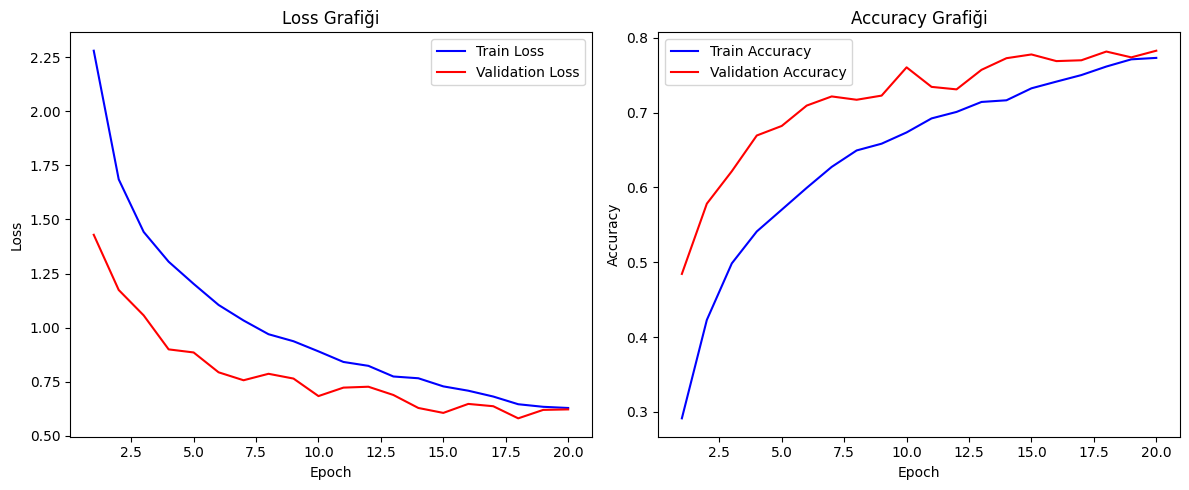

In [19]:
# Eğitim ve doğrulama kayıplarını ve doğruluklarını alma
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Kayıp grafiği
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Train Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Grafiği')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Doğruluk grafiği
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b', label='Train Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Accuracy Grafiği')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Modelin daha önce hiç görmediği test verileri üzerinden tahmin yapmasını sağlayarak eğitilmemiş verileri ne oranda sınıflandırdığını gösterdik. 

In [20]:
test_loss, test_acc = model.evaluate(x_test, y_test_encoded, verbose=0)
print(f"Test accuracy: {test_acc * 100:.2f}%")

Test accuracy: 76.56%


Son olarak da modelin performansını kayıp ve doğruluk oranlarına bakarak değerlendirdik. 

In [21]:
# Test verisinde modelin performansını değerlendirme
test_loss, test_accuracy = model.evaluate(x_test, y_test_encoded)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7778 - loss: 0.6112
Test Loss: 0.637404203414917
Test Accuracy: 0.7655555605888367
